In [ ]:
pip install datasets tensorflow opencv-python matplotlib pandas scikit-learn


In [ ]:
# Mount Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define DATASET_PATH here as well for this cell to run independently
DATASET_PATH = "/content/drive/MyDrive/Digital Image Processing/Data"  # Make sure this matches the path in the data loading cell

In [ ]:
# Verify the dataset path
print(f"Verifying dataset path: {DATASET_PATH}")
if os.path.exists(DATASET_PATH):
    print("Dataset path exists.")
    # List subdirectories to see if they exist
    subdirs = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    print(f"Found subdirectories: {subdirs}")
    # Check if there are any files in the first subdirectory found (if any)
    if subdirs:
        first_subdir = os.path.join(DATASET_PATH, subdirs[0])
        # Ensure the subdirectory is not empty before listing files
        if os.listdir(first_subdir):
            files_in_subdir = [f for f in os.listdir(first_subdir) if os.path.isfile(os.path.join(first_subdir, f))]
            print(f"Found {len(files_in_subdir)} files in the first subdirectory ({subdirs[0]}).")
            if files_in_subdir:
                print(f"First file in {subdirs[0]}: {files_in_subdir[0]}")
            else:
                 print(f"No files found in the first subdirectory ({subdirs[0]}).")
        else:
            print(f"The first subdirectory ({subdirs[0]}) is empty.")

    else:
        print("No subdirectories found in the dataset path.")
else:
    print("Dataset path does NOT exist. Please check the path in the code cell above.")

Verifying dataset path: /content/drive/MyDrive/Digital Image Processing/Data
Dataset path exists.
Found subdirectories: ['Test', 'Train']
Found 0 files in the first subdirectory (Test).
No files found in the first subdirectory (Test).


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

IMG_SIZE = 224  # Increased from 128 for better feature extraction
DATASET_PATH = "/content/drive/MyDrive/Digital Image Processing/Data/Train"  # Change to your path

images = []
labels = []

print("[INFO] Loading and processing TrashNet dataset...")

def enhance_image(img):
    # Resize to larger size for better feature extraction
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert BGR to RGB (important for pretrained CNNs)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply histogram equalization for better contrast
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Apply Gaussian blur to reduce noise
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Normalize with EfficientNet preprocess_input
    img = preprocess_input(img.astype("float32"))

    return img

[INFO] Loading and processing TrashNet dataset...


In [ ]:
# ========================
# Load dataset with better error handling
# ========================
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

for label_folder in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_folder)
    if not os.path.isdir(label_path):
        continue

    print(f"Processing {label_folder}...")
    for img_file in os.listdir(label_path):
        # Check if file has valid image extension
        if not any(img_file.lower().endswith(ext) for ext in valid_extensions):
            continue

        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None or img.size == 0:
                continue

            # Additional check for image dimensions
            if img.shape[0] < 32 or img.shape[1] < 32:
                continue

            enhanced_img = enhance_image(img)
            images.append(enhanced_img)
            labels.append(label_folder)
        except Exception as e:
            print(f"[WARN] Skipped corrupt image: {img_path} - {e}")

# Check if any images were loaded
if not images:
    raise ValueError("No images were loaded. Please check the DATASET_PATH and ensure there are readable images in the subdirectories.")


Processing plastic...
Processing trash...
Processing paper...
Processing metal...
Processing glass...
Processing cardboard...


In [ ]:
# ========================
# Convert to NumPy and balance dataset
# ========================
X = np.array(images, dtype="float32")
y = np.array(labels)

# Check class distribution
from collections import Counter
class_counts = Counter(y)
print(f"[INFO] Class distribution: {class_counts}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Stratified train-validation-test split (70-15-15)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_categorical, test_size=0.15, random_state=42, stratify=y_categorical
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"[INFO] Dataset ready: {len(X_train)} training, {len(X_val)} validation, {len(X_test)} test samples")
print(f"[INFO] Classes: {le.classes_}")


[INFO] Class distribution: Counter({np.str_('paper'): 504, np.str_('plastic'): 426, np.str_('glass'): 416, np.str_('metal'): 360, np.str_('cardboard'): 352, np.str_('trash'): 128})
[INFO] Dataset ready: 1530 training, 328 validation, 328 test samples
[INFO] Classes: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


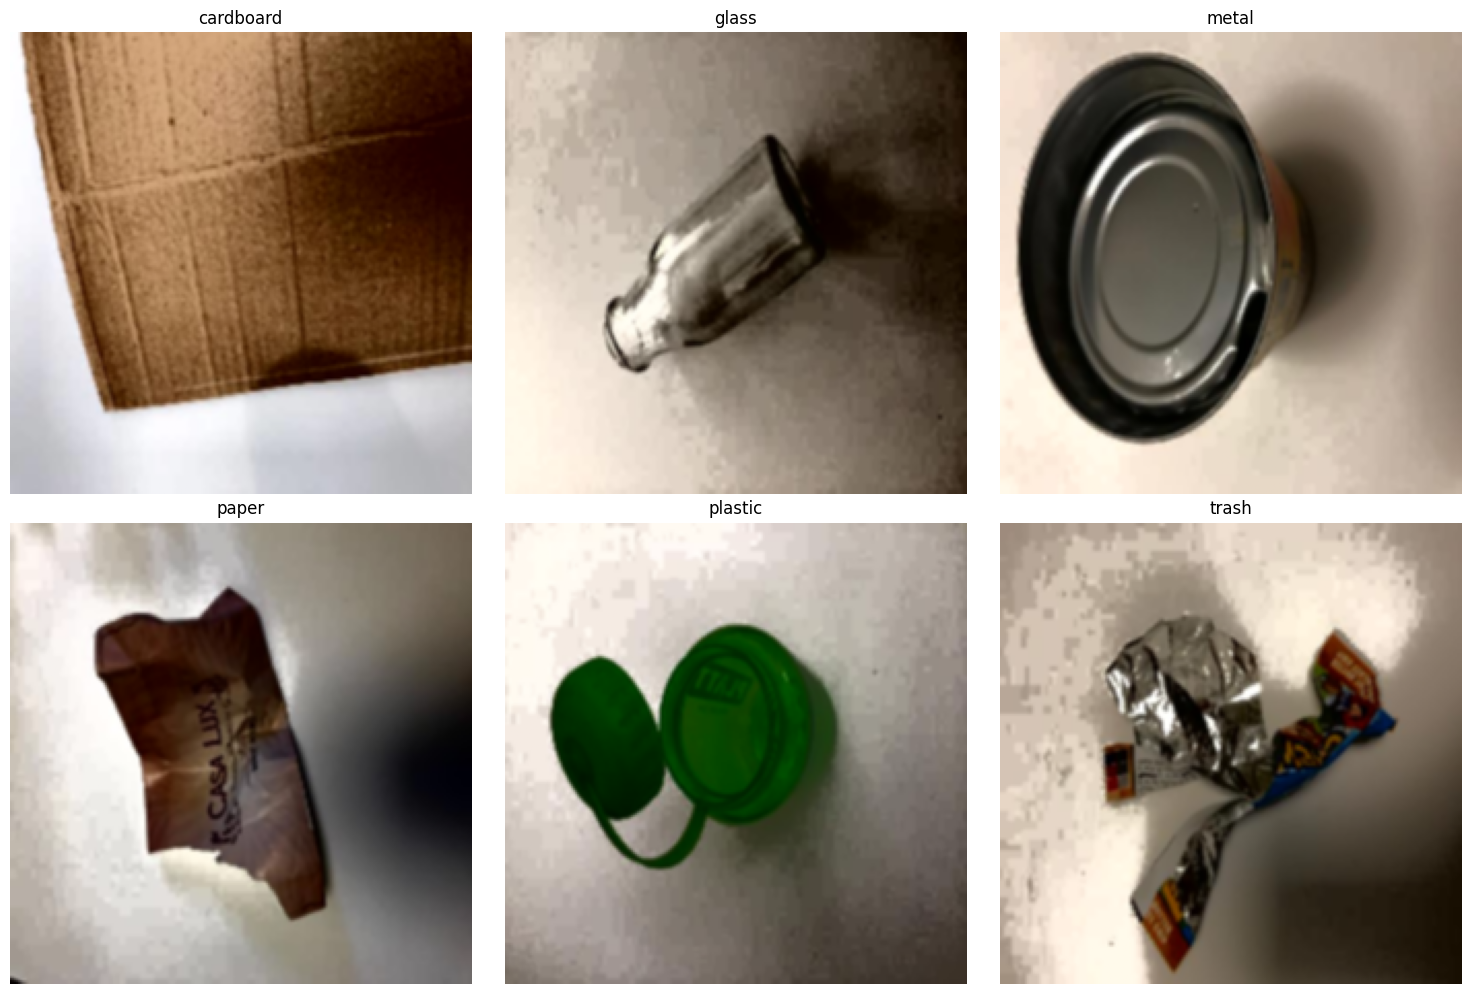

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display sample images from each class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, class_name in enumerate(le.classes_):
    if i >= 6:  # Limit to 6 classes for display
        break

    # Find first image of this class
    class_indices = np.where(np.argmax(y_train, axis=1) == i)[0]
    if len(class_indices) > 0:
        sample_idx = class_indices[0]
        sample_image = X_train[sample_idx]

        # Denormalize for display
        sample_image_display = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())

        axes[i].imshow(sample_image_display)
        axes[i].set_title(f"{class_name}")
        axes[i].axis("off")

plt.tight_layout()
plt.show()


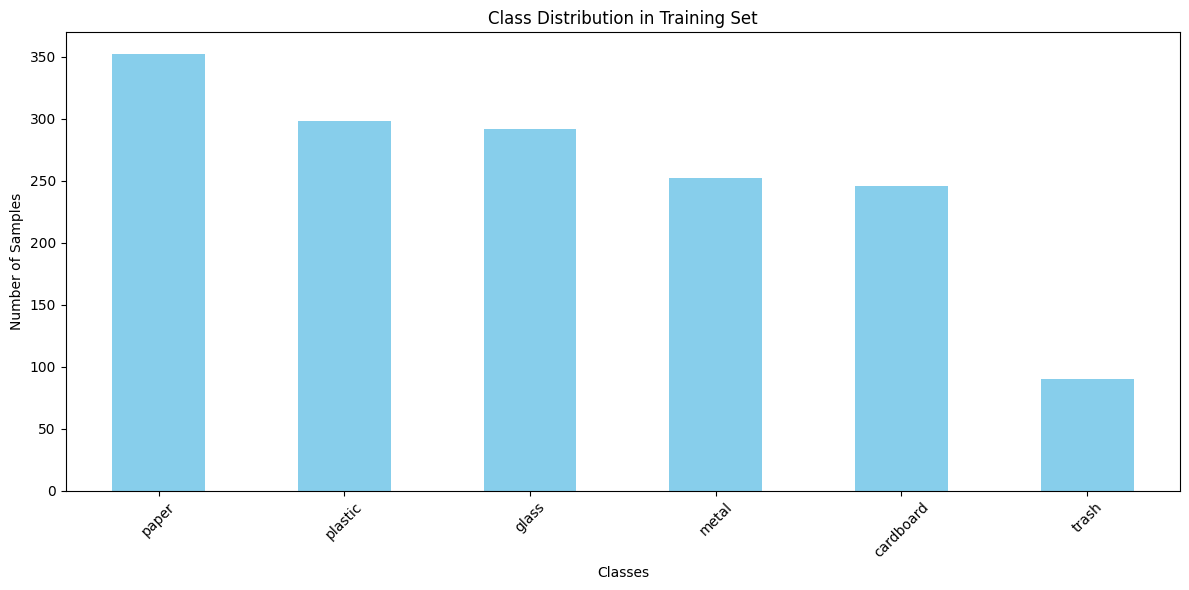

In [ ]:
import pandas as pd

# Enhanced class distribution visualization
class_names = le.inverse_transform(np.argmax(y_train, axis=1))
class_df = pd.Series(class_names).value_counts()

plt.figure(figsize=(12, 6))
class_df.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ========================
# Enhanced Data Augmentation
# ========================
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,  # Usually not good for object recognition
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.1,
    fill_mode="nearest",
    shear_range=0.2
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_advanced_model(num_classes, img_size=224):
    # Use EfficientNetB0 instead of MobileNetV2 for better accuracy
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(img_size, img_size, 3)
    )

    # Fine-tune the last few layers
    base_model.trainable = True
    for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
        layer.trainable = False

    # Add custom head with more sophisticated architecture
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create the model
model_advanced = create_advanced_model(y_train.shape[1], IMG_SIZE)

# Compile with different optimizers for different phases
model_advanced.compile(
    optimizer=Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy", "top_3_accuracy"]
)

print(f"[INFO] Model created with {model_advanced.count_params()} parameters")

[INFO] Model created with 4845481 parameters


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Custom learning rate scheduler
def cosine_annealing_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.5 * (1 + math.cos(math.pi * (epoch - 10) / 40))

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor="val_accuracy",
        verbose=1
    ),
    ReduceLROnPlateau(
        patience=7,
        factor=0.3,
        verbose=1,
        monitor="val_accuracy",
        min_lr=1e-7
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/Digital Image Processing/best_trashnet_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        verbose=1
    ),
    LearningRateScheduler(cosine_annealing_scheduler, verbose=1)
]

In [ ]:
# Phase 1: Train with frozen base model
print("[INFO] Phase 1: Training with frozen base model...")
for layer in model_advanced.layers[:-6]:  # Freeze all but custom head
    layer.trainable = False

model_advanced.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_k_accuracy')]
)

# Convert ImageDataGenerator output to tf.data.Dataset for potentially more stable training
train_ds = tf.data.Dataset.from_generator(
    lambda: train_datagen.flow(X_train, y_train, batch_size=16),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, y_train.shape[1]), dtype=tf.float32)
    )
).repeat() # Repeat the dataset indefinitely

history_phase1 = model_advanced.fit(
    train_ds,
    steps_per_epoch=len(X_train) // 16, # Need to set steps_per_epoch when using repeat()
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

[INFO] Phase 1: Training with frozen base model...

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4677 - loss: 11.3149 - top_k_accuracy: 0.8013
Epoch 1: val_accuracy improved from -inf to 0.76220, saving model to /content/drive/MyDrive/Digital Image Processing/best_trashnet_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.4688 - loss: 11.3034 - top_k_accuracy: 0.8021 - val_accuracy: 0.7622 - val_loss: 8.1937 - val_top_k_accuracy: 0.9695 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7399 - loss: 7.5864 - top_k_accuracy: 0.9642
Epoch 2: val_accuracy improved from 0.76220 to 0.79573, saving model to /content/drive/MyDrive/Digital Image Processing/best_trashnet_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.7400 - loss: 7.5804 - top_k_accura

In [ ]:
# Phase 2: Fine-tune the entire model
print("[INFO] Phase 2: Fine-tuning entire model...")
for layer in model_advanced.layers:
    layer.trainable = True

model_advanced.compile(
    optimizer=Adam(learning_rate=1e-5),  # Very low learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_k_accuracy')]
)

history_phase2 = model_advanced.fit(
    train_datagen.flow(X_train, y_train, batch_size=8),  # Smaller batch size
    steps_per_epoch=len(X_train) // 8,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

[INFO] Phase 2: Fine-tuning entire model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6051 - loss: 1.9273 - top_k_accuracy: 0.9092
Epoch 1: val_accuracy did not improve from 0.86280
191/191 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.6051 - loss: 1.9270 - top_k_accuracy: 0.9092 - val_accuracy: 0.7774 - val_loss: 1.3755 - val_top_k_accuracy: 0.9756 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/30
  1/191 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.5000 - loss: 2.7475 - top_k_accuracy: 0.6250

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.86280
191/191 ━━━━━━━━━━━━━━━━━━━━ 43s 216ms/step - accuracy: 0.5000 - loss: 2.7475 - top_k_accuracy: 0.6250 - val_accuracy: 0.7774 - val_loss: 1.3758 - val_top_k_accuracy: 0.9756 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6501 - loss: 1.8202 - top_k_accuracy: 0.9251
Epoch 3: val_accuracy did not improve from 0.86280
191/191 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.6500 - loss: 1.8202 - top_k_accuracy: 0.9251 - val_accuracy: 0.7927 - val_loss: 1.4780 - val_top_k_accuracy: 0.9756 - learning_rate: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/30
  1/191 ━━━━━━━━━━━━━━━━━━━━ 8:28 3s/step - accuracy: 0.2500 - loss: 2.3784 - top_k_accuracy: 0.7500
Epoch 4: val_accuracy did not improve from 0.86280
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - accuracy: 0.2500

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [ ]:


import keras_tuner
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_tuned_model(hp):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = True

    # Tune how many layers to freeze
    freeze_layers = hp.Int('freeze_layers', min_value=10, max_value=50, step=10)
    for layer in base_model.layers[:-freeze_layers]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)

    # Tune first dense layer
    dense1_units = hp.Int('dense1_units', min_value=256, max_value=1024, step=128)
    x = Dense(dense1_units, activation='relu', kernel_regularizer=l2(0.01))(x)

    # Tune dropout rate
    dropout1_rate = hp.Float('dropout1_rate', min_value=0.3, max_value=0.7, step=0.1)
    x = Dropout(dropout1_rate)(x)
    x = BatchNormalization()(x)

    # Tune second dense layer
    dense2_units = hp.Int('dense2_units', min_value=128, max_value=512, step=64)
    x = Dense(dense2_units, activation='relu', kernel_regularizer=l2(0.01))(x)

    dropout2_rate = hp.Float('dropout2_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(dropout2_rate)(x)

    output = Dense(y_train.shape[1], activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Hyperparameter tuning with more trials
tuner = keras_tuner.BayesianOptimization(  # Use Bayesian instead of Random
    build_tuned_model,
    objective='val_accuracy',
    max_trials=10,  # Increased trials
    directory='/content/drive/MyDrive/Digital Image Processing/tuning_dir',
    project_name='advanced_trashnet_tuning'
)

print("[INFO] Starting advanced hyperparameter search...")

# Search with validation data
tuner.search(
    X_train,
    y_train,
    epochs=15,
    validation_data=(X_val, y_val),
    batch_size=16,
    verbose=1
)

print("[INFO] Hyperparameter search complete.")

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("[INFO] Best Hyperparameters:")
print(f"Freeze Layers: {best_hp.get('freeze_layers')}")
print(f"Dense1 Units: {best_hp.get('dense1_units')}")
print(f"Dense2 Units: {best_hp.get('dense2_units')}")
print(f"Dropout1 Rate: {best_hp.get('dropout1_rate')}")
print(f"Dropout2 Rate: {best_hp.get('dropout2_rate')}")
print(f"Learning Rate: {best_hp.get('learning_rate')}")

Reloading Tuner from /content/drive/MyDrive/Digital Image Processing/tuning_dir/advanced_trashnet_tuning/tuner0.json
[INFO] Starting advanced hyperparameter search...
[INFO] Hyperparameter search complete.
[INFO] Best Hyperparameters:
Freeze Layers: 40
Dense1 Units: 640
Dense2 Units: 192
Dropout1 Rate: 0.3
Dropout2 Rate: 0.4
Learning Rate: 0.0005626412835536573


In [ ]:
# Build and train the best model
best_model = tuner.hypermodel.build(best_hp)

# Enhanced callbacks for final training
final_callbacks = [
    EarlyStopping(
        patience=20,
        restore_best_weights=True,
        monitor="val_accuracy",
        verbose=1
    ),
    ReduceLROnPlateau(
        patience=10,
        factor=0.2,
        verbose=1,
        monitor="val_accuracy",
        min_lr=1e-8
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/Digital Image Processing/final_best_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        verbose=1
    )
]

print("[INFO] Training final optimized model...")
final_history = best_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=len(X_train) // 16,
    validation_data=(X_val, y_val),
    epochs=20,  # More epochs for better convergence
    callbacks=final_callbacks,
    verbose=1
)


[INFO] Training final optimized model...
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4411 - loss: 12.7841
Epoch 1: val_accuracy improved from -inf to 0.78354, saving model to /content/drive/MyDrive/Digital Image Processing/final_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.4425 - loss: 12.7761 - val_accuracy: 0.7835 - val_loss: 10.6356 - learning_rate: 5.6264e-04
Epoch 2/20
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.6250 - loss: 11.0006
Epoch 2: val_accuracy improved from 0.78354 to 0.78963, saving model to /content/drive/MyDrive/Digital Image Processing/final_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.6250 - loss: 11.0006 - val_accuracy: 0.7896 - val_loss: 10.6175 - learning_rate: 5.6264e-04
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7501 - loss: 10.2029
Epoch 3: val_accuracy improved from 0.78963 to 0.85976, saving model to /content/drive/MyDrive/Digital Image Processing/final_be

In [ ]:
# Ensemble prediction for better accuracy
from tensorflow.keras.models import load_model

# Load the best models
model1 = load_model("/content/drive/MyDrive/Digital Image Processing/best_trashnet_model.keras")
model2 = load_model("/content/drive/MyDrive/Digital Image Processing/final_best_model.keras")

def ensemble_predict(models, X):
    predictions = []
    for model in models:
        pred = model.predict(X, verbose=0)
        predictions.append(pred)

    # Average the predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred

# Evaluate ensemble on test set
print("[INFO] Evaluating ensemble model...")
ensemble_pred = ensemble_predict([model1, model2], X_test)
ensemble_accuracy = np.mean(np.argmax(ensemble_pred, axis=1) == np.argmax(y_test, axis=1))

print(f"[RESULT] Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

[INFO] Evaluating ensemble model...
[RESULT] Ensemble Test Accuracy: 0.8902


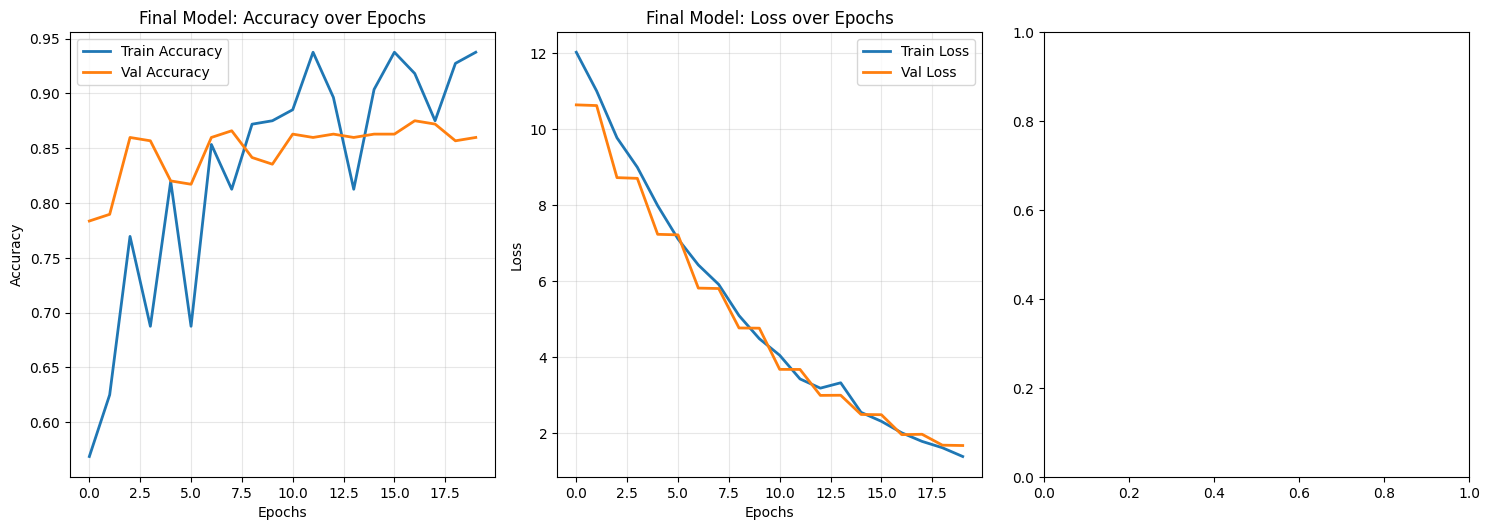

In [ ]:
# Enhanced visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Training history for final model
plt.subplot(2, 3, 1)
plt.plot(final_history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(final_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Final Model: Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(final_history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Final Model: Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate schedule
plt.subplot(2, 3, 3)
lr_history = final_history.history.get('lr', [])
if lr_history:
    plt.plot(lr_history, linewidth=2)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Use the best model for evaluation
eval_model = best_model

# Predictions
y_pred = eval_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Detailed Classification Report
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=le.classes_,
    digits=4
)
print(report)


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   cardboard     0.9778    0.8302    0.8980        53
       glass     0.9310    0.8710    0.9000        62
       metal     0.8750    0.9074    0.8909        54
       paper     0.8675    0.9474    0.9057        76
     plastic     0.9104    0.9531    0.9313        64
       trash     0.6842    0.6842    0.6842        19

    accuracy                         0.8933       328
   macro avg     0.8743    0.8655    0.8683       328
weighted avg     0.8963    0.8933    0.8931       328



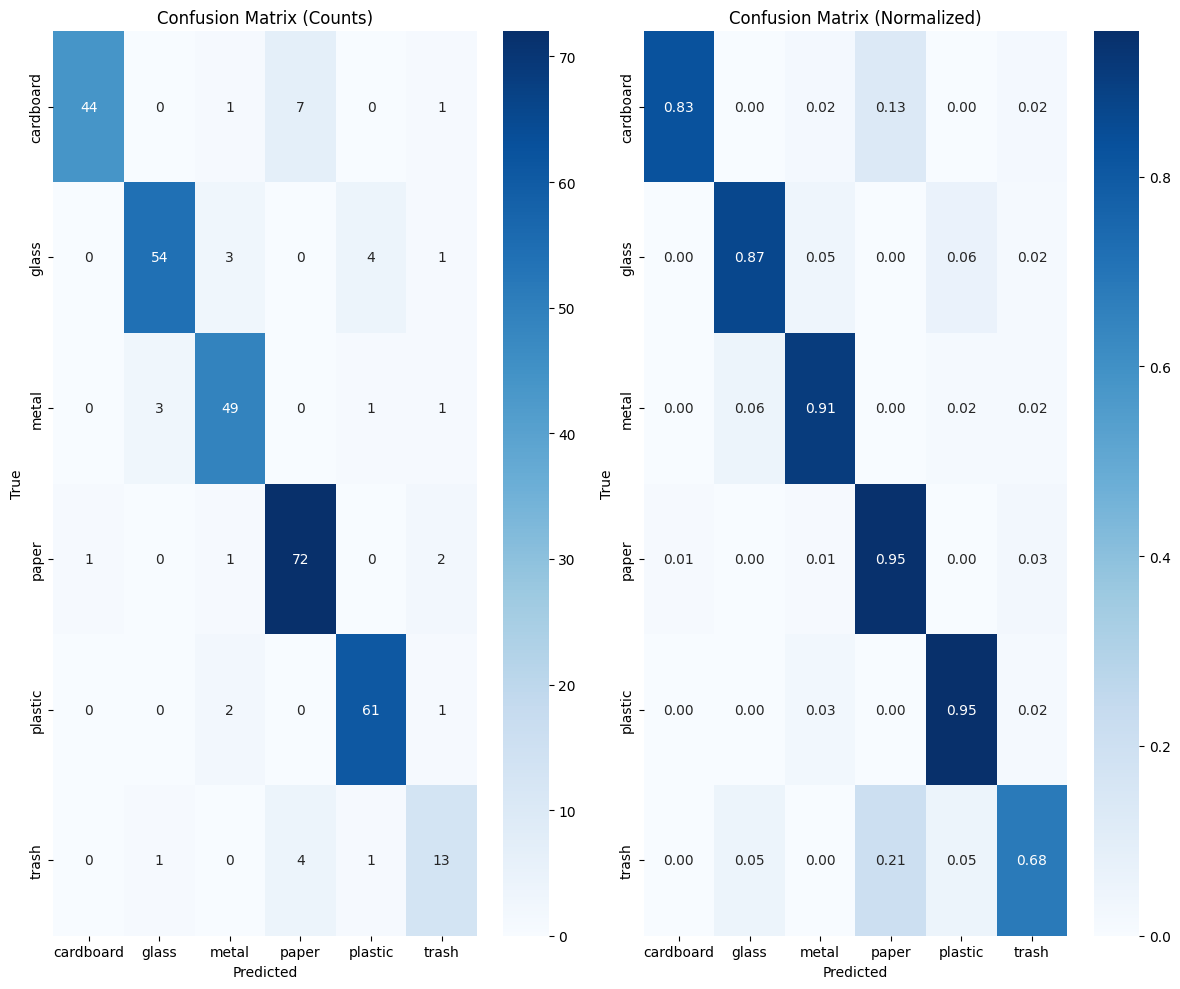

In [ ]:
# Enhanced Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {class_accuracies[i]:.4f}")

# Enhanced prediction function with confidence analysis
def enhanced_predict_and_show(model, img_path, label_encoder, top_k=3):
    """Enhanced prediction with top-k results and confidence analysis"""

    # Preprocess image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found: {img_path}")

    # Apply same preprocessing as training
    img_rgb = cv2.cvtColor(cv2.resize(img, (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB)

    # Apply histogram equalization
    img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Apply Gaussian blur
    img_rgb = cv2.GaussianBlur(img_rgb, (3, 3), 0)

    # Preprocess for model
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)

    # Predict
    preds = model.predict(img_input, verbose=0)

    # Get top-k predictions
    top_indices = np.argsort(preds[0])[::-1][:top_k]
    top_classes = label_encoder.inverse_transform(top_indices)
    top_confidences = preds[0][top_indices]

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {top_classes[0]} ({top_confidences[0]*100:.2f}%)")

    plt.subplot(1, 2, 2)
    plt.barh(range(top_k), top_confidences)
    plt.yticks(range(top_k), top_classes)
    plt.xlabel('Confidence')
    plt.title(f'Top-{top_k} Predictions')
    plt.xlim(0, 1)

    for i, (class_name, conf) in enumerate(zip(top_classes, top_confidences)):
        plt.text(conf + 0.01, i, f'{conf*100:.2f}%', va='center')

    plt.tight_layout()
    plt.show()

    return top_classes, top_confidences


cardboard: 0.8302
glass: 0.8710
metal: 0.9074
paper: 0.9474
plastic: 0.9531
trash: 0.6842



ENHANCED PREDICTION EXAMPLES


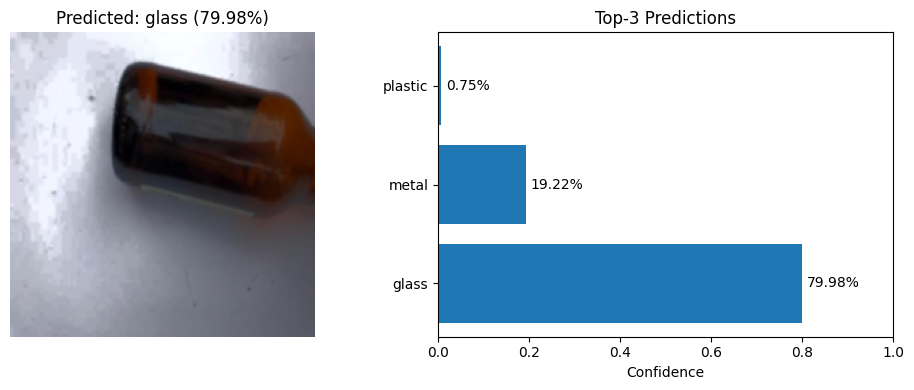

Image:
  1. glass: 79.98%
  2. metal: 19.22%
  3. plastic: 0.75%



In [ ]:
# Test enhanced prediction
print("\n" + "="*50)
print("ENHANCED PREDICTION EXAMPLES")
print("="*50)

# Test on cardboard
img_path = "/content/drive/MyDrive/Digital Image Processing/Data/Test/glass/glass421.jpg"
predicted_classes, confidences = enhanced_predict_and_show(best_model, img_path, le)

print(f"Image:")
for i, (cls, conf) in enumerate(zip(predicted_classes, confidences)):
    print(f"  {i+1}. {cls}: {conf*100:.2f}%")

print()

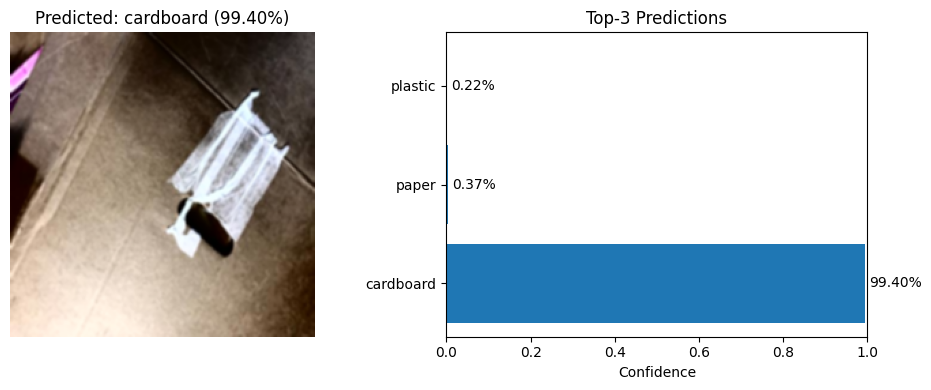

Image:
  1. cardboard: 99.40%
  2. paper: 0.37%
  3. plastic: 0.22%


In [ ]:
# Test on cardboard
img_path = "/content/drive/MyDrive/Digital Image Processing/Data/Test/cardboard/cardboard359.jpg"
predicted_classes, confidences = enhanced_predict_and_show(best_model, img_path, le)

print(f"Image:")
for i, (cls, conf) in enumerate(zip(predicted_classes, confidences)):
    print(f"  {i+1}. {cls}: {conf*100:.2f}%")


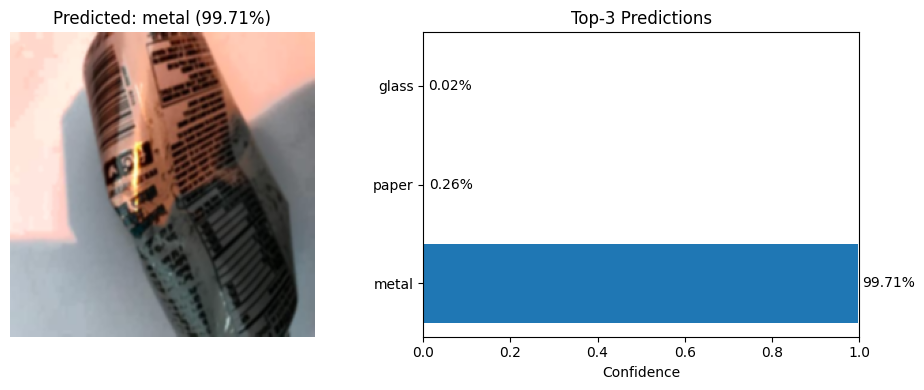

Image:
  1. metal: 99.71%
  2. paper: 0.26%
  3. glass: 0.02%


In [ ]:
# Test on metal
img_path = "/content/drive/MyDrive/Digital Image Processing/Data/Test/metal/metal364.jpg"
predicted_classes, confidences = enhanced_predict_and_show(best_model, img_path, le)

print(f"Image:")
for i, (cls, conf) in enumerate(zip(predicted_classes, confidences)):
    print(f"  {i+1}. {cls}: {conf*100:.2f}%")

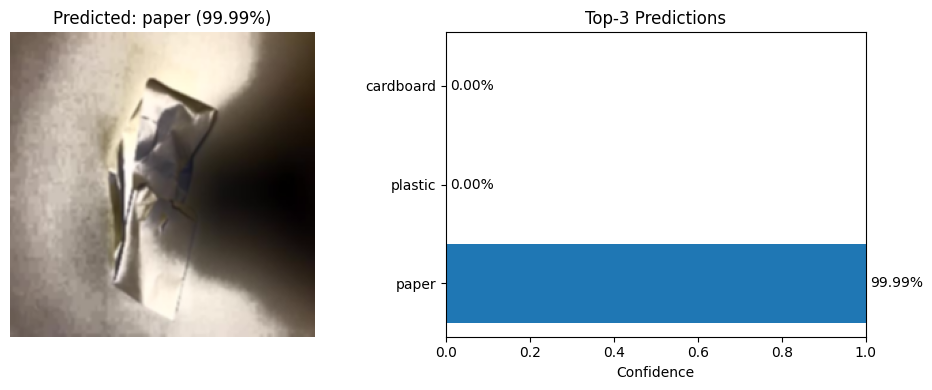

Image:
  1. paper: 99.99%
  2. plastic: 0.00%
  3. cardboard: 0.00%


In [ ]:
# Test on paper
img_path = "/content/drive/MyDrive/Digital Image Processing/Data/Test/paper/paper505.jpg"
predicted_classes, confidences = enhanced_predict_and_show(best_model, img_path, le)

print(f"Image:")
for i, (cls, conf) in enumerate(zip(predicted_classes, confidences)):
    print(f"  {i+1}. {cls}: {conf*100:.2f}%")

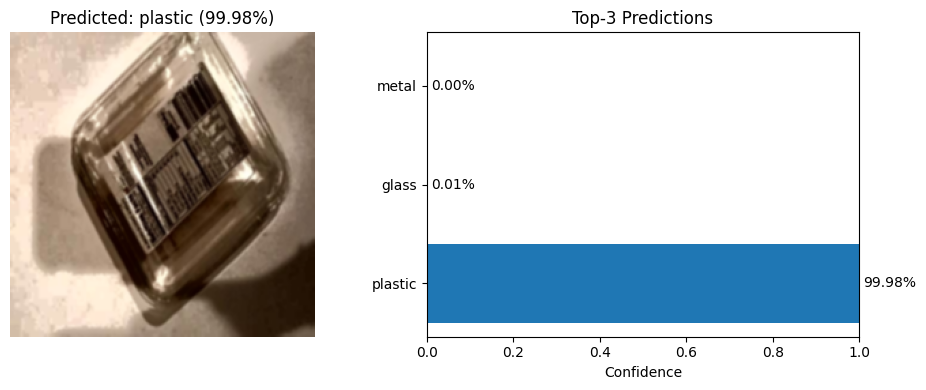

Image:
  1. plastic: 99.98%
  2. glass: 0.01%
  3. metal: 0.00%


In [ ]:
# Test on plastic
img_path = "/content/drive/MyDrive/Digital Image Processing/Data/Test/plastic/plastic443.jpg"
predicted_classes, confidences = enhanced_predict_and_show(best_model, img_path, le)

print(f"Image:")
for i, (cls, conf) in enumerate(zip(predicted_classes, confidences)):
    print(f"  {i+1}. {cls}: {conf*100:.2f}%")

In [ ]:
import pickle

# Save the best model and necessary data for inference
model_data = {
    "model": best_model,
    "label_encoder": le,
    "img_size": IMG_SIZE
}

with open("/content/drive/MyDrive/Digital Image Processing/garbageModel.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("[INFO] Model and data saved as garbageModel.pkl")

[INFO] Model and data saved as garbageModel.pkl


In [ ]:
# Save the best model in Keras format
best_model.save("/content/drive/MyDrive/Digital Image Processing/garbageModel.keras")

print("[INFO] Model saved as garbageModel.keras")

[INFO] Model saved as garbageModel.keras


In [ ]:
# Save the best model in HDF5 format
best_model.save("/content/drive/MyDrive/Digital Image Processing/garbageModel.h5")

print("[INFO] Model saved as garbageModel.h5")

[INFO] Model saved as garbageModel.h5


In [ ]:
import pickle

# Load the model and data from the pickle file
with open("/content/drive/MyDrive/Digital Image Processing/garbageModel.pkl", "rb") as f:
    loaded_model_data = pickle.load(f)

# Access the loaded components
loaded_model = loaded_model_data["model"]
loaded_label_encoder = loaded_model_data["label_encoder"]
loaded_img_size = loaded_model_data["img_size"]

print("[INFO] Model and data loaded from garbageModel.pkl")
print(f"Loaded model type: {type(loaded_model)}")
print(f"Loaded label encoder classes: {loaded_label_encoder.classes_}")
print(f"Loaded image size: {loaded_img_size}")

[INFO] Model and data loaded from garbageModel.pkl
Loaded model type: <class 'keras.src.models.functional.Functional'>
Loaded label encoder classes: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']
Loaded image size: 224



CLASSIFICATION USING LOADED PKL MODEL


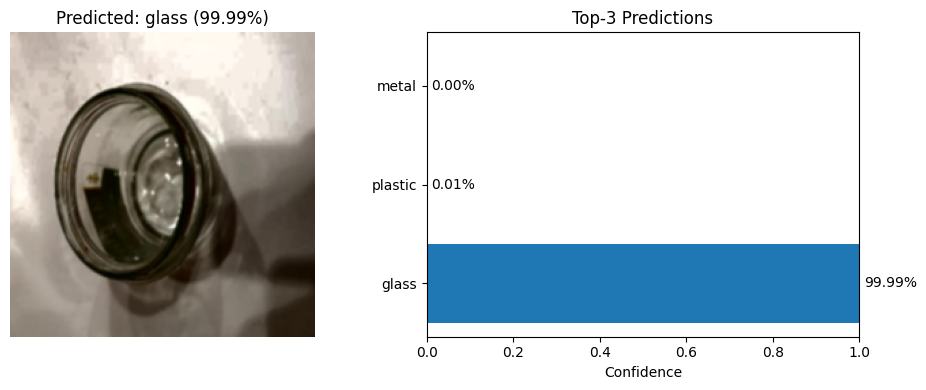

Image: /content/drive/MyDrive/Digital Image Processing/Data/Test/glass/glass419.jpg
  1. glass: 99.99%
  2. plastic: 0.01%
  3. metal: 0.00%


In [ ]:
# Classify a cardboard image using the loaded model
print("\n" + "="*50)
print("CLASSIFICATION USING LOADED PKL MODEL")
print("="*50)

# Use an example cardboard image from the test set
cardboard_img_path = "/content/drive/MyDrive/Digital Image Processing/Data/Test/glass/glass419.jpg" # Replace with an actual path if needed

try:
    predicted_classes_pkl, confidences_pkl = enhanced_predict_and_show(
        loaded_model,
        cardboard_img_path,
        loaded_label_encoder
    )

    print(f"Image: {cardboard_img_path}")
    for i, (cls, conf) in enumerate(zip(predicted_classes_pkl, confidences_pkl)):
        print(f"  {i+1}. {cls}: {conf*100:.2f}%")

except Exception as e:
    print(f"An error occurred during prediction: {e}")

[INFO] Model loaded successfully from /content/drive/MyDrive/Digital Image Processing/final_best_model.keras

CLASSIFICATION USING LOADED KERAS MODEL


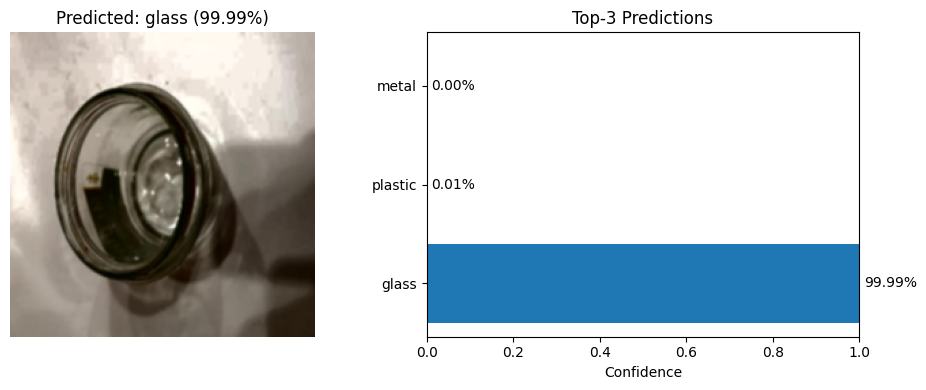

Image: /content/drive/MyDrive/Digital Image Processing/Data/Test/glass/glass419.jpg
  1. glass: 99.99%
  2. plastic: 0.01%
  3. metal: 0.00%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
import os

# Define IMG_SIZE here as well for this cell to run independently
IMG_SIZE = 224

# Load the model
try:
    model_path = "/content/drive/MyDrive/Digital Image Processing/final_best_model.keras"
    loaded_model = load_model(model_path)
    print(f"[INFO] Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    loaded_model = None


# Assuming `le` (LabelEncoder) is available from previous cells
# If not, you might need to load it from a file or re-create it based on your data
# For this example, we'll assume it's available. If not, you'll need to add code here to load/create it.
# Example:
# try:
#     with open("/content/drive/MyDrive/Digital Image Processing/label_encoder.pkl", "rb") as f:
#         loaded_label_encoder = pickle.load(f)
# except Exception as e:
#     print(f"Error loading LabelEncoder: {e}")
#     loaded_label_encoder = None
#     # You might need to recreate it if loading fails and you don't have a saved one.
#     # loaded_label_encoder = LabelEncoder()
#     # loaded_label_encoder.fit(y_train) # Assuming y_train is available


def enhanced_predict_and_show(model, img_path, label_encoder, top_k=3):
    """Enhanced prediction with top-k results and confidence analysis"""

    # Preprocess image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found: {img_path}")

    # Apply same preprocessing as training
    img_rgb = cv2.cvtColor(cv2.resize(img, (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB)

    # Apply histogram equalization
    img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Apply Gaussian blur
    img_rgb = cv2.GaussianBlur(img_rgb, (3, 3), 0)

    # Preprocess for model
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)

    # Predict
    preds = model.predict(img_input, verbose=0)

    # Get top-k predictions
    top_indices = np.argsort(preds[0])[::-1][:top_k]
    top_classes = label_encoder.inverse_transform(top_indices)
    top_confidences = preds[0][top_indices]

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {top_classes[0]} ({top_confidences[0]*100:.2f}%)")

    plt.subplot(1, 2, 2)
    plt.barh(range(top_k), top_confidences)
    plt.yticks(range(top_k), top_classes)
    plt.xlabel('Confidence')
    plt.title(f'Top-{top_k} Predictions')
    plt.xlim(0, 1)

    for i, (class_name, conf) in enumerate(zip(top_classes, top_confidences)):
        plt.text(conf + 0.01, i, f'{conf*100:.2f}%', va='center')

    plt.tight_layout()
    plt.show()

    return top_classes, top_confidences


if loaded_model and 'le' in locals(): # Ensure model is loaded and le is available
    print("\n" + "="*50)
    print("CLASSIFICATION USING LOADED KERAS MODEL")
    print("="*50)

    # Use an example cardboard image from the test set
    cardboard_img_path = "/content/drive/MyDrive/Digital Image Processing/Data/Test/glass/glass419.jpg" # Replace with an actual path if needed

    try:
        predicted_classes_keras, confidences_keras = enhanced_predict_and_show(
            loaded_model,
            cardboard_img_path,
            le # Use the 'le' variable from previous cells
        )

        print(f"Image: {cardboard_img_path}")
        for i, (cls, conf) in enumerate(zip(predicted_classes_keras, confidences_keras)):
            print(f"  {i+1}. {cls}: {conf*100:.2f}%")

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
else:
    print("[ERROR] Model not loaded or LabelEncoder ('le') not found.")